### Стандартные импорты и настройки

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Scipy

Импортируем функции из библиотеки для кластеризации и векторного квантования.

https://docs.scipy.org/doc/scipy-0.18.1/reference/cluster.vq.html

In [2]:
from scipy.cluster.vq import whiten, kmeans2

### Подключаем API

Для примера используем открытое API, которое предоставляет данные о футбольных командах и матчах. 

http://api.football-data.org/docs/v1/index.html

Для полноценного использования лучше всего получить ключ, это довольно просто.

http://api.football-data.org/client/register

Для удобства зададим вспомогательный метод для обращения к API.

In [3]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': '6343e2401b274e4b9d3233b7291115e5' }).json()
        return json[result_key]
    except:
        print(json)
        return None

Получаем команды

In [4]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': None},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players'},
   'self': {'href

Для каждой команды получаем игроков и игры.

In [5]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    goals = 0
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            goals += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            goals += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
    print('Team "{}", {} players, {} goals'.format(team['name'], len(players), goals))
    team['players'] = players
    team['goals'] = goals

Team "FC Rio Ave", 27 players, 11 goals
Team "FC Porto", 25 players, 41 goals
Team "Moreirense FC", 28 players, 7 goals
Team "FC Paços de Ferreira", 26 players, 14 goals
Team "Sporting CP", 27 players, 34 goals
Team "Maritimo Funchal", 29 players, 13 goals
Team "CD Tondela", 27 players, 15 goals
Team "SL Benfica", 31 players, 30 goals
Team "Boavista Porto FC", 37 players, 13 goals
Team "FC Arouca", 22 players, 0 goals
Team "Vitoria Setubal", 26 players, 12 goals
Team "C.F. Os Belenenses", 26 players, 13 goals
Team "Vitoria Guimaraes", 25 players, 15 goals
Team "Sporting Braga", 30 players, 22 goals
Team "GD Estoril Praia", 28 players, 8 goals
Team "Feirense", 29 players, 11 goals
Team "Nacional Funchal", 18 players, 0 goals
Team "G.D. Chaves", 25 players, 15 goals


Готовим данные для трансформации в Pandas

In [6]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append({'name': team['name'], 'players': len(team['players']), 'goals': team['goals']})
team_for_pd

[{'goals': 11, 'name': 'FC Rio Ave', 'players': 27},
 {'goals': 41, 'name': 'FC Porto', 'players': 25},
 {'goals': 7, 'name': 'Moreirense FC', 'players': 28},
 {'goals': 14, 'name': 'FC Paços de Ferreira', 'players': 26},
 {'goals': 34, 'name': 'Sporting CP', 'players': 27},
 {'goals': 13, 'name': 'Maritimo Funchal', 'players': 29},
 {'goals': 15, 'name': 'CD Tondela', 'players': 27},
 {'goals': 30, 'name': 'SL Benfica', 'players': 31},
 {'goals': 13, 'name': 'Boavista Porto FC', 'players': 37},
 {'goals': 0, 'name': 'FC Arouca', 'players': 22},
 {'goals': 12, 'name': 'Vitoria Setubal', 'players': 26},
 {'goals': 13, 'name': 'C.F. Os Belenenses', 'players': 26},
 {'goals': 15, 'name': 'Vitoria Guimaraes', 'players': 25},
 {'goals': 22, 'name': 'Sporting Braga', 'players': 30},
 {'goals': 8, 'name': 'GD Estoril Praia', 'players': 28},
 {'goals': 11, 'name': 'Feirense', 'players': 29},
 {'goals': 0, 'name': 'Nacional Funchal', 'players': 18},
 {'goals': 15, 'name': 'G.D. Chaves', 'player

Трансформируем

In [7]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,goals,name,players
0,11,FC Rio Ave,27
1,41,FC Porto,25
2,7,Moreirense FC,28
3,14,FC Paços de Ferreira,26
4,34,Sporting CP,27
5,13,Maritimo Funchal,29
6,15,CD Tondela,27
7,30,SL Benfica,31
8,13,Boavista Porto FC,37
9,0,FC Arouca,22


Отображаем

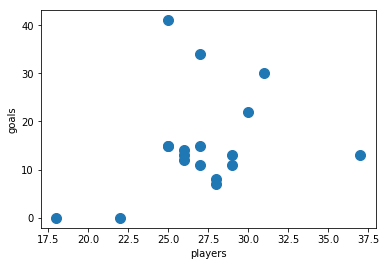

In [8]:
teams_pd.plot.scatter(x='players', y='goals', s=100)

Удаляем колонку с именами

In [9]:
del teams_pd['name']
teams_pd

,goals,players
0,11,27
1,41,25
2,7,28
3,14,26
4,34,27
5,13,29
6,15,27
7,30,31
8,13,37
9,0,22


Нормализация данных

In [10]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 1.06310353,  7.15945616],
       [ 3.96247679,  6.62912607],
       [ 0.67652043,  7.4246212 ],
       [ 1.35304086,  6.89429112],
       [ 3.28595636,  7.15945616],
       [ 1.25639508,  7.68978625],
       [ 1.44968663,  7.15945616],
       [ 2.89937326,  8.22011633],
       [ 1.25639508,  9.81110659],
       [ 0.        ,  5.83363094],
       [ 1.1597493 ,  6.89429112],
       [ 1.25639508,  6.89429112],
       [ 1.44968663,  6.62912607],
       [ 2.12620706,  7.95495129],
       [ 0.7731662 ,  7.4246212 ],
       [ 1.06310353,  7.68978625],
       [ 0.        ,  4.77297077],
       [ 1.44968663,  6.62912607]])

Сделаем 3 кластера

In [11]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 2.0939918 ,  8.66205807],
        [ 3.62421658,  6.89429112],
        [ 0.99619492,  6.85349649]]),
 array([2, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2], dtype=int32))

Зададим цвета для каждого кластера

In [12]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['b',
 'g',
 'b',
 'b',
 'g',
 'b',
 'b',
 'r',
 'r',
 'b',
 'b',
 'b',
 'b',
 'r',
 'b',
 'b',
 'b',
 'b']

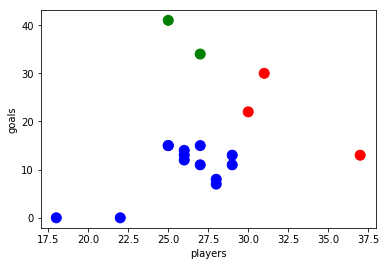

In [13]:
teams_pd.plot.scatter(x='players', y='goals', c=colors, s=100)

Теперь попробуем сделать больше кластеров.

In [14]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 3.96247679,  6.62912607],
        [ 0.95265121,  6.36396103],
        [ 3.28595636,  7.15945616],
        [ 1.07691007,  7.76554769],
        [ 2.51279016,  8.08753381]]),
 array([3, 0, 3, 1, 2, 3, 3, 4, 3, 1, 1, 1, 1, 4, 3, 3, 1, 1], dtype=int32))

In [15]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['y',
 'r',
 'y',
 'g',
 'b',
 'y',
 'y',
 'm',
 'y',
 'g',
 'g',
 'g',
 'g',
 'm',
 'y',
 'y',
 'g',
 'g']

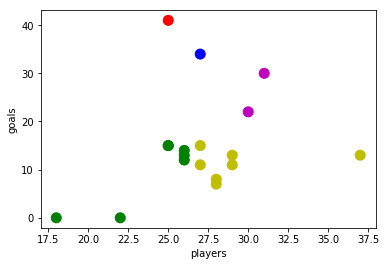

In [16]:
teams_pd.plot.scatter(x='players', y='goals', c=colors, s=100)

In [22]:
centroids, cluster_map = kmeans2(whitened, 8)
centroids, cluster_map

/Users/npenzin/Conda3/lib/python3.6/site-packages/scipy/cluster/vq.py:523: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


(array([[ 1.25639508,  9.81110659],
        [ 0.96645775,  7.47765421],
        [ 2.51279016,  8.08753381],
        [ 1.3337117 ,  6.7882251 ],
        [ 0.8393109 ,  6.7495264 ],
        [ 0.        ,  5.30330086],
        [ 3.62421658,  6.89429112],
        [ 1.44968663,  7.15945616]]),
 array([1, 6, 1, 3, 6, 1, 7, 2, 0, 5, 3, 3, 3, 2, 1, 1, 5, 3], dtype=int32))